# Spiking data and population burst events 


In [ ]:
%matplotlib notebook

## Read spike data 

### Spike data was stored in a MATLAB data structure and here we need to retrieve it. It contains information on spike timing, spatial tuning, stability, animal velocity at spike time, etc

### Cluster Quality (L-ratios)

In [ ]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import h5py
import mplcursors

data_dir = r'D:\NCMLProject\Datasets\Achilles_10252013'

# Load .mat file
filename = 'Achilles_10252013.clusterQuality.mat'
file_path = os.path.join(data_dir, filename)

mat_file = scipy.io.loadmat(file_path)

# Access data structure
Lratios = mat_file["clusterQuality"]["Lratio"]

print(type(Lratios))
print(Lratios.shape) # a 3-dimensional array with number of shanks as the third dimension 



### convert the loaded .mat file to dataframe using Pandas library

#### In order to access the Lratios between units belonging to each shank: 

##### (for ecample shank 4)

In [ ]:
LRatios_example_shank = Lratios[:, 11][0] # two times sclicing in order to access the data

print(LRatios_example_shank)
print(LRatios_example_shank.dtype)
print(LRatios_example_shank.shape)


#####  Plot the L-ratios for the example shank

In [ ]:
num_units, num_units = LRatios_example_shank.shape

# Flatten the array to create a 1D array of all values
all_LRatios = LRatios_example_shank.flatten()

# Calculate the 5th and 95th percentiles. 
vmin, vmax = np.nanpercentile(all_LRatios, [5, 95])

p25, median, p75 = np.nanpercentile(all_LRatios, [25, 50, 75])

print(p25, median, p75)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))



# Plot a histogram of all L-Ratios
all_Lratios_filtered = all_LRatios[(all_LRatios >= vmin) & (all_LRatios <= vmax)]

ax1.hist(all_Lratios_filtered)
ax1.set_title('Histogram of all L-ratios')
ax1.set_xlabel('L-Ratio')
ax1.set_ylabel('Frequecny')


# Display the L-Ratios as an image using imshow()


img = ax2.imshow(LRatios_example_shank, vmin = vmin, vmax = vmax) # limit the range in color code to 5 and 95 percentiles
cb = fig.colorbar(img, ax = ax2, label = 'L-Ratio')

ax2.set_xticks(range(num_units))
ax2.set_yticks(range(num_units))

ax2.set_xticklabels([str(i+1) for i in range(num_units)])
ax2.set_yticklabels([str(i+1) for i in range(num_units)])


ax2.set_xlabel('Units')
ax2.set_ylabel('Units')


plt.show()

##### Calculate how many pairs satisfy the criterion L-Ratio < 1e-3 

In [ ]:
LRatio_thresh = 1e-3
small_LRation_percentage = all_LRatios[all_LRatios <= LRatio_thresh].size/all_LRatios.size
print(small_LRation_percentage)

### Place Fields

#### Import the .mat file and see if we can plot the place field of an example unit 

In [ ]:
data_dir = r'D:\NCMLProject\Datasets\Achilles_10252013'

# Load .mat file
filename = 'Achilles_10252013.spikes_for_python.mat'
file_path = os.path.join(data_dir, filename)

mat_file = scipy.io.loadmat(file_path)
spikes_pyr = mat_file["spikes_pyr"]

# plot the spatial tuning for an example unit

unit_index = 32
example_unit_spatial_tuning = spikes_pyr["spatialTuning_smoothed"][0][unit_index]['LR'][0][0] 

plt.plot(example_unit_spatial_tuning)
plt.xlabel("position bin")
plt.ylabel("firing rate (Hz)")
plt.title("Example unit spatial tuning")


#### Extracting all place fields from the imported .mat file

148 95


<IPython.core.display.Javascript object>


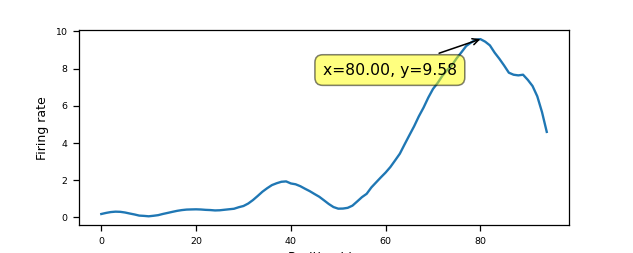

position bin with the peak firing rate is 81


In [547]:
spatial_tuning_smoothed = spikes_pyr["spatialTuning_smoothed"]

num_units    = spatial_tuning_smoothed[0].shape[0]
num_pos_bins = spatial_tuning_smoothed[0][0]['uni'][0][0].size

print(num_units, num_pos_bins)

place_fields = [];
peak_pos_bins = [];

# attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
running_directions = {'LR', 'RL', 'uni'}
for unit in range(num_units):
    
    # Create dictionaries for each unit and store the matrices
    unit_place_fields = {}
    unit_peak_pos_bins = {}
    for direction in running_directions:
        unit_place_fields[direction] = spatial_tuning_smoothed[0][unit][direction][0][0].reshape(num_pos_bins) 
        unit_peak_pos_bins[direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]
        
    place_fields.append(unit_place_fields) 
    peak_pos_bins.append(unit_peak_pos_bins)
    
    
    
# pltttong the place field corresponding to a running direction for an example unit
example_unit = 5;

fig, ax = plt.subplots(figsize=(5, 2), dpi=100)

ax.plot(place_fields[example_unit]['uni'])

ax.tick_params(axis='both', which='major', length=4, labelsize= 6) 
ax.set_xlabel("Position bin", fontsize=8)
ax.set_ylabel("Firing rate", fontsize=8)

# Set up the cursor to display values on click
cursor = mplcursors.cursor(ax, hover=True)
cursor.connect('add', lambda sel: sel.annotation.set_text(
    f'x={sel.target[0]:.2f}, y={sel.target[1]:.2f}'))

plt.show()

print(f"position bin with the peak firing rate is {peak_pos_bins[example_unit]['uni']}")


#### Plot place fields sorted based on the peak firing rate locations 


In [ ]:
peak_place_field_sorting_indices = np.argsort(peak_pos_bins)

# Create an array of original row indices
original_row_indices = np.arange(place_fields.shape[0])


place_fields_sorted = place_fields[peak_place_field_sorting_indices]
original_row_indices_sorted = original_row_indices[peak_place_field_sorting_indices]


# Find the maximum value in each row of the matrix
max_vals = np.amax(place_fields_sorted, axis=1)

# Create a boolean mask for rows with a maximum value >= 1
mask = max_vals >= 1

# Select the rows that you want to plot
selected_rows = place_fields_sorted[mask]
selected_row_indices = original_row_indices_sorted[mask]

# Normalize each curve to a maximum of 1
selected_rows = selected_rows / np.amax(selected_rows, axis=1, keepdims=True) * 0.9

# Define the x-axis values (e.g. position bins)
x = np.arange(place_fields.shape[1])

# Create the plot
fig, ax = plt.subplots(figsize=(2, 5), dpi=200)

# Set the colormap to "viridis"
cmap = plt.get_cmap("plasma")

# Loop over each selected row of the matrix and plot a filled curve
for i in range(selected_rows.shape[0]):
    y = selected_rows[i]  # Select the i-th row of the matrix
    ax.fill_between(x, y + i, i, where=y > 0, interpolate=True, alpha=0.2, color=cmap(i/selected_rows.shape[0]))
    ax.plot(x, y + i, color=cmap(i/selected_rows.shape[0]), alpha=1, linewidth=0.5)

# Set the y-axis limits and labels
ax.set_ylim(-1, selected_rows.shape[0] + 1)
ax.set_yticks(np.arange(selected_rows.shape[0]))
ax.set_yticklabels(np.arange(selected_rows.shape[0]) + 1)

# Set the x-axis limits and labels
ax.set_xlim(x[0], x[-1])
ax.set_xlabel("Position (cm)", fontsize=8)
ax.set_ylabel("Unit", fontsize=8)
ax.set_yticks([]) # set y-axis ticks to an empty list
ax.tick_params(axis='both', which='major', length=4, labelsize= 6) # remove y-axis tick marks


# Set x-axis tick labels in intervals of 10 and multiply by 2
new_ticks = [int(bin)*2 for bin in range(num_pos_bins)[::25]]
ax.set_xticks(range(num_pos_bins)[::25])
ax.set_xticklabels(new_ticks)

# Remove the box
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add white space
# fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)
fig.tight_layout()

# Show the plot
plt.show()

# fig.savefig("myplot.pdf", format="pdf")

### Population burst events (PBEs)

In [ ]:
data_dir = r'D:\NCMLProject\Datasets\Achilles_10252013';
filename = 'Achilles_10252013.PBEInfo_replayScores.mat'

file_path = os.path.join(data_dir, filename)
f = h5py.File(file_path, "r")

PBEInfo = f['PBEInfo_replayScores']

print(list(PBEInfo.keys()))

#### Store the population burst events in a new variable 


In [ ]:
# Define a list of PBE dictionaries
PBEs = []

# Define the number of PBEs and matrix types
num_PBEs = PBEInfo["fr_1msbin"].shape[0]

attributes = list(PBEInfo.keys())

# Loop over the PBEs and create a dictionary for each one
for pbe in range(num_PBEs): 
    # Create a dictionary for the PBE and store the matrices
    PBE_dict = {}
    for attr in attributes:
        ref = PBEInfo[attr][pbe][0]
        obj = f[ref] 
        PBE_dict[attr] = np.array(obj) 

    PBEs.append(PBE_dict)
    

#### An example PBE 

In [ ]:
# Create the plot for firing 

PBE_firing_rate = PBEs[7]["fr_20msbin"].transpose()

fig, ax = plt.subplots(figsize=(5, 5), dpi=200)


ax.imshow(PBE_firing_rate, aspect = 0.05)

ax.tick_params(axis='both', which='major', length=4, labelsize= 6) # remove y-axis tick marks
ax.set_xlabel("Time bin", fontsize=8)
ax.set_ylabel("Unit", fontsize=8)
cb = fig.colorbar(img, ax = ax, label = 'Spike count')

# Set up the cursor to display values on click
cursor = mplcursors.cursor(ax, hover=False)
cursor.connect('add', lambda sel: sel.annotation.set_text(
    f'x={sel.target[0]:.2f}, y={sel.target[1]:.2f}'))

plt.show()

# fig.savefig("myplot.pdf", format="pdf")